In [328]:
import pandas_datareader.data as web
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import scipy.optimize as optimize
from numpy import random
import yfinance as yfin

# Data Acquisition

For this assignment, two sets of five stocks were selected from two different sectors. 

Five stocks were selected from the tech sector:
* Apple
* Microsoft
* Google
* Meta
* NVIDIA

and five were selected from the consumer sector:
* Amazon
* Tesla
* Home Depot
* Toyota Motors
* Nike

In [338]:
startdate= datetime(year=2017,month=12,day=30)
enddate= datetime(year=2018,month=12,day=31)
ticks=['AAPL', 'MSFT', 'GOOGL', 'META', 'NVDA', 'AMZN', 'TSLA', 'PG', 'KO', 'NKE', '^SP500TR']
data = {}

# pull data for each stock
for tick in ticks:
    data[tick] = web.DataReader(tick,'yahoo',startdate, enddate).drop(columns=['High', 'Low', 'Open', 'Close', 'Volume'])

In [362]:
ticks_no_sp = ticks[:-1]
ticks_tech = ticks[:5]
ticks_consumer = ticks[5:-1]

# Compute daily returns
for tick in ticks:
    data[tick]["returns"] = data[tick]['Adj Close'].pct_change()

In [340]:
# Calculate daily risk free interest rate using US 3 Month T-Bill rates
fed_data= web.DataReader(['TB3SMFFM','FEDFUNDS'],'fred',startdate,datetime(year=2019,month=1,day=1))
fed_data['3MO T-BILL']=fed_data['TB3SMFFM']+fed_data['FEDFUNDS']
fed_3mo_daily= (fed_data['3MO T-BILL'].resample(rule='B').ffill().to_frame())/(100*252)

In [341]:
# Subtract risk free interest rates to calculate the excess expected returns
for tick in ticks:
    data[tick]["excess_expected_returns"] = data[tick]['returns'].subtract(fed_3mo_daily['3MO T-BILL'].iloc[1:])

# Create dataframe for expected returns
expectedReturns = pd.DataFrame()
for tick in ticks:
    expectedReturns[tick] = data[tick]["excess_expected_returns"].dropna()

# Data Analysis
# Q1

In [342]:
#1A
# Compute expected return and risk for the S&P 500
sigma_sp500 = expectedReturns["^SP500TR"].std()
mu_sp500 = expectedReturns["^SP500TR"].mean()
print("(sigma, mu) = (" + str(round(sigma_sp500, 5)) + ", " + str(round(mu_sp500, 5)) + ")")

# Calculate and display the three covariance matrices
covariance = expectedReturns.cov()
covariance_tech = expectedReturns[ticks_tech].cov()
covariance_consumer = expectedReturns[ticks_consumer].cov()

display(covariance)
display(covariance_tech)
display(covariance_consumer)

(sigma, mu) = (0.01076, -0.00023)


,AAPL,MSFT,GOOGL,META,NVDA,AMZN,TSLA,PG,KO,NKE,^SP500TR
AAPL,0.000328,0.000226,0.000215,0.000193,0.000289,0.000272,0.000213,0.000052,0.000040,0.000139,0.000145
MSFT,0.000226,0.000318,0.000260,0.000235,0.000348,0.000315,0.000257,0.000055,0.000061,0.000177,0.000168
GOOGL,0.000215,0.000260,0.000315,0.000266,0.000360,0.000299,0.000225,0.000041,0.000049,0.000153,0.000158
META,0.000193,0.000235,0.000266,0.000574,0.000371,0.000315,0.000245,0.000029,0.000039,0.000122,0.000147
NVDA,0.000289,0.000348,0.000360,0.000371,0.000960,0.000451,0.000333,0.000044,0.000047,0.000241,0.000220
AMZN,0.000272,0.000315,0.000299,0.000315,0.000451,0.000518,0.000300,0.000034,0.000041,0.000195,0.000188
TSLA,0.000213,0.000257,0.000225,0.000245,0.000333,0.000300,0.001363,0.000087,0.000071,0.000219,0.000159
PG,0.000052,0.000055,0.000041,0.000029,0.000044,0.000034,0.000087,0.000149,0.000078,0.000056,0.000054
KO,0.000040,0.000061,0.000049,0.000039,0.000047,0.000041,0.000071,0.000078,0.000089,0.000068,0.000054
NKE,0.000139,0.000177,0.000153,0.000122,0.000241,0.000195,0.000219,0.000056,0.000068,0.000343,0.000124


,AAPL,MSFT,GOOGL,META,NVDA
AAPL,0.000328,0.000226,0.000215,0.000193,0.000289
MSFT,0.000226,0.000318,0.000260,0.000235,0.000348
GOOGL,0.000215,0.000260,0.000315,0.000266,0.000360
META,0.000193,0.000235,0.000266,0.000574,0.000371
NVDA,0.000289,0.000348,0.000360,0.000371,0.000960


,AMZN,TSLA,PG,KO,NKE
AMZN,0.000518,0.000300,0.000034,0.000041,0.000195
TSLA,0.000300,0.001363,0.000087,0.000071,0.000219
PG,0.000034,0.000087,0.000149,0.000078,0.000056
KO,0.000041,0.000071,0.000078,0.000089,0.000068
NKE,0.000195,0.000219,0.000056,0.000068,0.000343


In [343]:
#1B
condition = np.linalg.cond(covariance)
condition_tech = np.linalg.cond(covariance_tech)
condition_consumer = np.linalg.cond(covariance_consumer)

print("Condition Number for all selected stocks: " + str(condition))
print("Condition Number for tech sector: " + str(condition_tech))
print("Condition Number for consumer sector: " + str(condition_consumer))

Condition Number for all selected stocks: 273.97308543927574
Condition Number for tech sector: 31.309784357943844
Condition Number for consumer sector: 45.80244647341031


The signs of the covariances for every stock is positive, showing that as the market goes up, so do these stocks. These stocks are all positively correlated with each other as well, showing that generally speaking, when their respective sector goes up, so does the individual stock. The condition number for all of the stocks together is relatively high, while the individual sectors are relatively low. Each sector serves as a more stable system than everything together.

In [344]:
singleFactorReturns = pd.DataFrame()

for tick in ticks[:-1]:
    beta = expectedReturns[tick].cov(expectedReturns['^SP500TR']) / expectedReturns['^SP500TR'].var()
    alpha = expectedReturns[tick].mean() - beta * expectedReturns['^SP500TR'].mean()
    singleFactorReturns[tick] = expectedReturns[tick] - alpha + beta * expectedReturns['^SP500TR']

display(singleFactorReturns.cov())

,AAPL,MSFT,GOOGL,META,NVDA,AMZN,TSLA,PG,KO,NKE
AAPL,0.000874,0.000856,0.000808,0.000745,0.001118,0.000978,0.000809,0.000255,0.000244,0.000604
MSFT,0.000856,0.001046,0.000944,0.000873,0.001305,0.001130,0.000946,0.000288,0.000296,0.000714
GOOGL,0.000808,0.000944,0.000959,0.000865,0.001260,0.001065,0.000872,0.000261,0.000270,0.000658
META,0.000745,0.000873,0.000865,0.001132,0.001210,0.001029,0.000848,0.000233,0.000245,0.000593
NVDA,0.001118,0.001305,0.001260,0.001210,0.002220,0.001523,0.001239,0.000351,0.000357,0.000947
AMZN,0.000978,0.001130,0.001065,0.001029,0.001523,0.001430,0.001071,0.000295,0.000305,0.000796
TSLA,0.000809,0.000946,0.000872,0.000848,0.001239,0.001071,0.002015,0.000308,0.000294,0.000727
PG,0.000255,0.000288,0.000261,0.000233,0.000351,0.000295,0.000308,0.000224,0.000153,0.000228
KO,0.000244,0.000296,0.000270,0.000245,0.000357,0.000305,0.000294,0.000153,0.000165,0.000241
NKE,0.000604,0.000714,0.000658,0.000593,0.000947,0.000796,0.000727,0.000228,0.000241,0.000739


In [393]:
def mp_mvp(ticks, sector):
    covariance = expectedReturns[ticks].cov()
    covariance_inv = np.linalg.inv(covariance)
    m_ex = expectedReturns[ticks].mean()
    w_mp_d = (1/(np.ones(len(ticks)) @ covariance_inv @ m_ex))
    w_mp_n = (covariance_inv @ m_ex)
    w_mp = w_mp_d * w_mp_n
    mu_mp =  m_ex.T @ w_mp 
    sigma_mp = np.sqrt(w_mp @ covariance @ w_mp)
    print(sector + " MP: (sigma, mu) = (" + str(round(sigma_mp, 5)) + ", " + str(round(mu_mp, 5)) + ")")
    print(sector + " weights: " + str(w_mp))

    sigma_mvp = 1/(np.sqrt(np.ones(len(ticks)).T @ covariance_inv @ np.ones(len(ticks))))
    mu_mvp = (np.ones(len(ticks)).T @ covariance_inv @ m_ex) / (np.ones(len(ticks)).T @ covariance_inv @np.ones(len(ticks)))
    print(sector + " MVP: (sigma, mu) = (" + str(round(sigma_mvp, 5)) + ", " + str(round(mu_mvp, 5)) + ")")


    sigma_ef = []
    mu_ef = np.linspace(-0.5, 0.5, 2000)

    mu = expectedReturns[ticks].mean()
    for i in mu_ef:
        mu_t=np.array([i,1])
        m_t=np.concatenate((mu.values.reshape((len(ticks),1)),np.ones((len(ticks),1))),axis=1)
        B=m_t.T@np.linalg.inv(covariance)@m_t
        sigma_v= np.sqrt(mu_t.T@np.linalg.inv(B)@m_t.T@np.linalg.inv(covariance)@m_t@np.linalg.inv(B)@mu_t)
        sigma_ef.append(sigma_v)

    risk_free_rate = fed_3mo_daily['3MO T-BILL'].iloc[1:].mean()
    plt.figure()
    plt.plot(sigma_ef,mu_ef,label="Efficient Frontier")
    plt.scatter(0,risk_free_rate,label="Risk Free Rate")
    plt.scatter(sigma_mvp,mu_mvp,label="MVP")
    plt.scatter(sigma_mp,mu_mp,label="MP")
    plt.plot([0,sigma_mp],[risk_free_rate,mu_mp],label="CML")
    plt.grid()
    plt.legend()
    plt.axis([0, 0.2, -0.05, 0.05])
    plt.title("Markowitz Bullet for " + sector)

    return sigma_mp, mu_mp, w_mp

All Stocks MP: (sigma, mu) = (0.1023, 0.01569)
All Stocks weights: [-3.16107993  4.88062468 -1.90233505 -2.46499245 -2.26418386  4.22488984
  0.12911733  0.28705653  0.31955313  0.95134979]
All Stocks MVP: (sigma, mu) = (0.00888, 0.00012)
Technology MP: (sigma, mu) = (0.16635, 0.02108)
Technology weights: [-4.26982312 14.75355813 -2.29653016 -3.88605061 -3.30115424]
Technology MVP: (sigma, mu) = (0.01578, 0.00019)
Consumer MP: (sigma, mu) = (0.01364, 0.00075)
Consumer weights: [ 0.42368963 -0.01428062 -0.08626563  0.42817631  0.2486803 ]
Consumer MVP: (sigma, mu) = (0.00912, 0.00033)


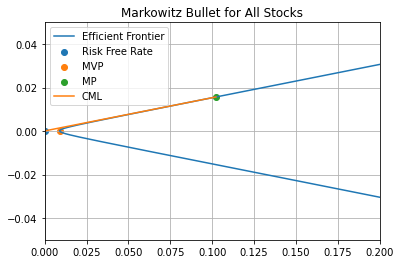

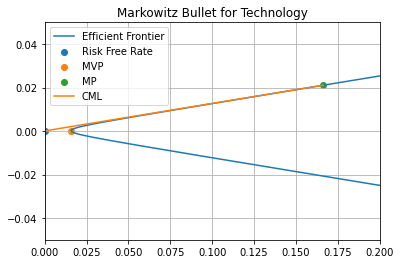

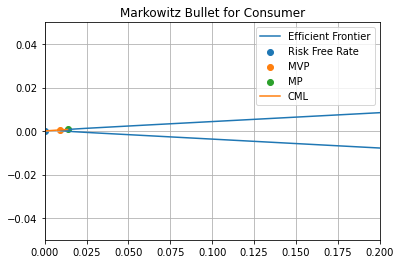

In [394]:
sigma_mp_all, mu_mp_all, w_mp_all = mp_mvp(ticks_no_sp, 'All Stocks')
sigma_mp_tech, mu_mp_tech, w_mp_tech = mp_mvp(ticks_tech, 'Technology')
sigma_mp_consumer, mu_mp_consumer, w_mp_consumer = mp_mvp(ticks_consumer, 'Consumer')

In [ ]:
# Calculate betas relative to full set
betas_full = pd.DataFrame()
for tick in ticks_no_sp:
    betas_full[tick] = [expectedReturns[tick].cov(w_mp_all * expectedReturns[tick])]/expectedReturns["^SP500TR"].var()

# Q2

In [363]:
def sml(ticks, sector):
    jan_returns = pd.DataFrame()
    betas = pd.DataFrame()
    for tick in ticks[:-1]:
        jan_returns[tick] = data[tick]["excess_expected_returns"].head(21).dropna()
        betas[tick] = [jan_returns[tick].cov(expectedReturns["^SP500TR"])]/expectedReturns["^SP500TR"].var()

    betas['^SP500TR'] = 1
    avg_daily_feb = pd.DataFrame()
    for tick in ticks:
        avg_daily_feb[tick] = [data[tick]["excess_expected_returns"].iloc[21: 40].mean()]

    print(avg_daily_feb)
    plt.figure()
    plt.scatter(betas, avg_daily_feb)
    plt.plot(np.array([0, 1], dtype=object), np.array([0, avg_daily_feb['^SP500TR']], dtype=object))
    plt.title("SML line for " + sector +" sector")

       AAPL      MSFT     GOOGL      META     NVDA      AMZN      TSLA  \
0  0.003662 -0.000231 -0.003347 -0.002235 -0.00023  0.002401 -0.001347   

         PG        KO       NKE  ^SP500TR  
0 -0.004933 -0.005009 -0.000739 -0.001895  
       AAPL      MSFT     GOOGL      META     NVDA  ^SP500TR
0  0.003662 -0.000231 -0.003347 -0.002235 -0.00023 -0.001895
       AMZN      TSLA        PG        KO       NKE  ^SP500TR
0  0.002401 -0.001347 -0.004933 -0.005009 -0.000739 -0.001895


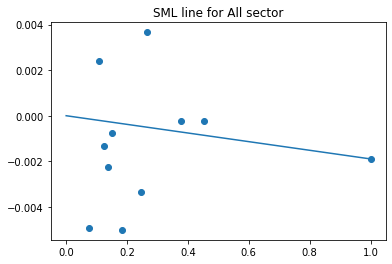

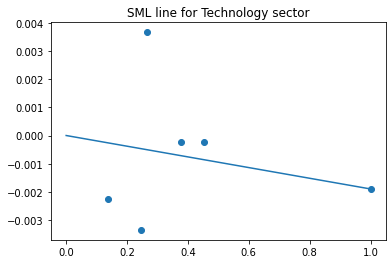

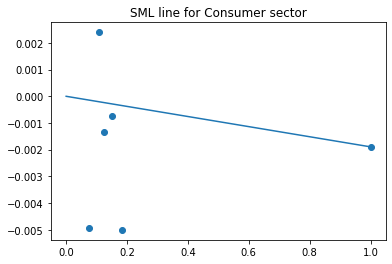

In [364]:
sml(ticks, "All")
sml([*ticks_tech, '^SP500TR'],"Technology")
sml([*ticks_consumer, '^SP500TR'],"Consumer")

# Q3

In [ ]:
def get_mp(ticks):
    jan_returns = pd.DataFrame()
    betas = pd.DataFrame()
    for tick in ticks[:-1]:
        jan_returns[tick] = data[tick]["excess_expected_returns"].head(21).dropna()
        betas[tick] = [jan_returns[tick].cov(expectedReturns["^SP500TR"])]/expectedReturns["^SP500TR"].var()

    covariance = expectedReturns[ticks].cov()
    covariance_inv = np.linalg.inv(covariance)
    m_ex = expectedReturns[ticks].mean()
    w_mp_d = (1/(np.ones(len(ticks)) @ covariance_inv @ m_ex))
    w_mp_n = (covariance_inv @ m_ex)
    w_mp = w_mp_d * w_mp_n
    mu_mp =  m_ex.T @ w_mp 
    sigma_mp = np.sqrt(w_mp @ covariance @ w_mp)

get_mp()